# TFM - Predicción potenciales compradores de un ecommerce

Evolución del notebook *Modelo_1.ipynb* unicamente se tendrá un dataset **acotado a las altas** y sepredicirá los clientes de las altas.

------------------------------------

------------------

### 1.1 Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier

from collections import Counter

pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings("ignore")

------------------

### 1.2 Variables globales

In [2]:
LABELS = ["No_Cliente","Cliente"]

------------------

### 1.3 Funciones

In [3]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize = (8, 8))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = "d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

------------------------------------

------------------

A continuación comenzamos leyendo los ficheros que hemos tratado, limpiado y analizado en los procesos anteriores.

Se realizará un análisis sencillo de la estructura y una visualización de varias muestras. 

Además someteremos las variables categóricas a variables *dummies*, de forma que que podamos introducirlas ennuestro modelo.

### 2.1 Lectura de Fichero

In [4]:
df = pd.read_csv('Data/dataset_model.txt', sep = ';', encoding = 'ISO-8859-1')

In [5]:
df.shape

(367632, 55)

In [6]:
df.head(3)

,TIPOUSUARIO,FECHA_REGISTRO_BUSINESS_DAY,FECHA_REGISTRO_WEEKDAY,FECHA_REGISTRO_MONTH,CANAL_REGISTRO,FECHA_ALTA_BUSINESS_DAY,FECHA_ALTA_WEEKDAY,FECHA_ALTA_MONTH,REGISTRO_ALTA,IND_ALTA,FECHA_CLIENTE_BUSINESS_DAY,FECHA_CLIENTE_WEEKDAY,FECHA_CLIENTE_MONTH,IND_CLIENTE,TIPOEMAIL,EMAIL_PERSONAL,BONDAD_EMAIL,TIPO_TELF,IPCASOS,IP_CONTINENTE,IP_COLOMBIA,IP_COUNTRY_PIB,IP_COUNTRY_IDH_NUM,IP_COUNTRY_IDH_GROUP,USU_TIPO,USU_TAMANIO,USU_ESTADO,USU_SECTOR_ECONOMICO,USU_DEPART_DEN_POB,USU_DEPART_IDH,FECHACONSUMO_BUSINESS_DAY,FECHACONSUMO_WEEKDAY,FECHACONSUMO_MONTH,ALTA_CONSUMO,CLIENTE_CONSUMO,1A_DESCGRUPOPROD,1A_EMPCONSUL_EST,1A_EMPCONSUL_SECTOR,1A_EMPCONSUL_PROV_DENS,1A_EMPCONSUL_PROV_IDH,CONSUM_TOT,FICH_PROMO_TOT,PERF_PROMO_TOT,RES_PAGO_TOT,EST_ACTIVA_TOT,EST_INACTIVA_TOT,EST_REESTRUCT_TOT,EST_CLINTON_TOT,EST_NI_TOT,SECT_PRIM_TOT,SECT_SECU_TOT,SECT_TERC_TOT,SECT_CUAT_TOT,SECT_QUIN_TOT,SECT_SD_TOT
0,PF,1,1,10,3,-1,-1,-1,-1,0,-1,-1,-1,0,GOOHOTYAHMAIL,1,0,NO_PUBLICO,1,AMERICA_SUR,1,Ingreso mediano alto,0.767,Alto,NoApl,NoApl,NoApl,NoApl,-1.00,-1.000,1,1,10,-1,-1,PERF_PROMO,ACTIVA,TERCIARIO,47.92,0.782,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0
1,PJ,1,1,5,3,-1,-1,-1,-1,0,-1,-1,-1,0,GOOHOTYAHMAIL,1,1,NO_PUBLICO,1,AMERICA_SUR,1,Ingreso mediano alto,0.767,Alto,SOC_COMERCIAL_INDUSTRIAL,PQ,ACTIVA,TERCIARIO,306.38,0.832,1,1,5,-1,-1,PERF_PROMO,ACTIVA,SD,47.92,0.782,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1
2,PJ,1,2,9,7,-1,-1,-1,-1,0,-1,-1,-1,0,GOOHOTYAHMAIL,1,1,NO_PUBLICO,1,AMERICA_SUR,1,Ingreso mediano alto,0.767,Alto,SOC_COMERCIAL_INDUSTRIAL,MC,ACTIVA,TERCIARIO,815.17,0.835,1,2,9,-1,-1,PERF_PROMO,ACTIVA,TERCIARIO,4438.75,0.904,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0


------------------

### 2.2 Variables dummies

In [7]:
ohe_columns = ['TIPOUSUARIO','TIPOEMAIL','TIPO_TELF','IP_CONTINENTE','IP_COUNTRY_PIB','IP_COUNTRY_IDH_GROUP','USU_TIPO','USU_TAMANIO','USU_ESTADO','USU_SECTOR_ECONOMICO',
               '1A_DESCGRUPOPROD','1A_EMPCONSUL_EST','1A_EMPCONSUL_SECTOR']

In [8]:
final_df = pd.get_dummies(df, columns = ohe_columns)

**Columnas para la predicción**

In [9]:
columnas = ['TIPOUSUARIO_PF','TIPOUSUARIO_PJ','FECHA_REGISTRO_BUSINESS_DAY','FECHA_REGISTRO_WEEKDAY','FECHA_REGISTRO_MONTH','CANAL_REGISTRO','FECHA_ALTA_BUSINESS_DAY',
            'FECHA_ALTA_WEEKDAY','FECHA_ALTA_MONTH','REGISTRO_ALTA','TIPOEMAIL_ADMINISTRACION','TIPOEMAIL_CORPORATIVO','TIPOEMAIL_DOCENTE','TIPOEMAIL_GOOHOTYAHMAIL',
            'TIPOEMAIL_SINCLASIFICAR','TIPOEMAIL_TEMPORAL','BONDAD_EMAIL','TIPO_TELF_EXTRANJERO','TIPO_TELF_MOVIL','TIPO_TELF_NO_PUBLICO','IPCASOS','IP_CONTINENTE_AFRICA',
            'IP_CONTINENTE_AMERICA_NORTE','IP_CONTINENTE_AMERICA_SUR','IP_CONTINENTE_ASIA','IP_CONTINENTE_EUROPA','IP_CONTINENTE_NI','IP_CONTINENTE_OCEANNIA','IP_COLOMBIA',
            'IP_COUNTRY_PIB_Ingreso alto','IP_COUNTRY_PIB_Ingreso mediano alto','IP_COUNTRY_PIB_NI','IP_COUNTRY_PIB_Países de ingreso mediano bajo','IP_COUNTRY_IDH_NUM',
            'USU_TIPO_EMPRESARIO INDIVIDUAL','USU_TIPO_ENTIDAD_HOLDING','USU_TIPO_NI','USU_TIPO_NoApl','USU_TIPO_SOC_COMERCIAL_INDUSTRIAL','USU_TIPO_SOC_NO_COMERCIAL',
            'USU_TAMANIO_GR','USU_TAMANIO_MC','USU_TAMANIO_MD','USU_TAMANIO_NoApl','USU_TAMANIO_PQ','USU_TAMANIO_SD','USU_ESTADO_ACTIVA','USU_ESTADO_INACTIVA','USU_ESTADO_NoApl',
            'USU_ESTADO_REESTRUCTURACION','USU_ESTADO_RELACION_CLINTON','USU_ESTADO_SD','USU_SECTOR_ECONOMICO_CUATERNARIO','USU_SECTOR_ECONOMICO_NoApl','USU_SECTOR_ECONOMICO_PRIMARIO',
            'USU_SECTOR_ECONOMICO_QUINARIO','USU_SECTOR_ECONOMICO_SD','USU_SECTOR_ECONOMICO_SECUNDARIO','USU_SECTOR_ECONOMICO_TERCIARIO','USU_DEPART_DEN_POB','USU_DEPART_IDH',
            'FECHACONSUMO_BUSINESS_DAY','FECHACONSUMO_WEEKDAY','FECHACONSUMO_MONTH','ALTA_CONSUMO','1A_DESCGRUPOPROD_FICH_PROMO','1A_DESCGRUPOPROD_PERF_PROMO',
            '1A_DESCGRUPOPROD_RES_PAGO','1A_EMPCONSUL_EST_ACTIVA','1A_EMPCONSUL_EST_INACTIVA','1A_EMPCONSUL_EST_NI','1A_EMPCONSUL_EST_REESTRUCTURACION',
            '1A_EMPCONSUL_EST_RELACION_CLINTON','1A_EMPCONSUL_SECTOR_CUATERNARIO','1A_EMPCONSUL_SECTOR_PRIMARIO','1A_EMPCONSUL_SECTOR_QUINARIO','1A_EMPCONSUL_SECTOR_SD',
            '1A_EMPCONSUL_SECTOR_SECUNDARIO','1A_EMPCONSUL_SECTOR_TERCIARIO','1A_EMPCONSUL_PROV_DENS','1A_EMPCONSUL_PROV_IDH','FICH_PROMO_TOT','PERF_PROMO_TOT']

-----------------

------------------

### 3.1 Analisis desbalanceo

In [10]:
final_df.loc[final_df['IND_ALTA'] == 1].shape

(3709, 108)

In [11]:
pd.value_counts(final_df.loc[final_df['IND_ALTA'] == 1, 'IND_CLIENTE'], sort = True)

1    2614
0    1095
Name: IND_CLIENTE, dtype: int64

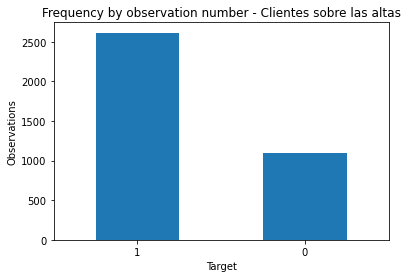

In [12]:
count_classes = pd.value_counts(final_df.loc[final_df['IND_ALTA'] == 1, 'IND_CLIENTE'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Frequency by observation number - Clientes sobre las altas")
plt.xlabel("Target")
plt.ylabel("Observations");

In [13]:
print('Los clientes suponen un % del total: ', (2614/final_df.loc[final_df['IND_ALTA'] == 1].shape[0])*100)

Los clientes suponen un % del total:  70.47721757886222


------------------

------------------

### 4. Creación del Modelo

#### 4.1 Dividimos el set entre features y label

In [14]:
features = final_df.loc[final_df['IND_ALTA'] == 1, columnas]
labels = final_df.loc[final_df['IND_ALTA'] == 1, 'IND_CLIENTE']

In [15]:
features.shape

(3709, 83)

In [16]:
labels.shape

(3709,)

------------------

#### 4.2 Creamos set de entrenamiento y test

In [17]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size = 0.3, random_state = 123)

In [18]:
train_x.shape

(2596, 83)

In [19]:
test_x.shape

(1113, 83)

In [20]:
train_y.shape

(2596,)

In [21]:
test_y.shape

(1113,)

------------------

#### 4.3 Selección Hiperparámetros

Definimos una serie de hiperparámetros diferentes para comparar resultados

In [22]:
param_grid = ParameterGrid({'n_estimators': [5, 20, 50, 100, 150],
                            'max_features': [5, 'log2', 'auto', 'sqrt'],
                            'max_depth'   : [None, 3, 5, 7, 10],
                            'criterion'   : ['gini', 'entropy'],
                            'class_weight': ['balanced']
                           })

Loop para ajustar un modelo con cada combinación de hiperparámetros

In [23]:
resultados = {'params': [], 'oob_accuracy': []}

In [24]:
for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(train_x, train_y)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 5} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 20} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 5} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 20} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 50} ✓
Modelo: {'class_weight': 'balanced', 'cri

In [25]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados.head(10)

,oob_accuracy,class_weight,criterion,max_depth,max_features,n_estimators
19,0.705316,balanced,gini,NaN,sqrt,150
14,0.705316,balanced,gini,NaN,auto,150
114,0.702234,balanced,entropy,NaN,auto,150
119,0.702234,balanced,entropy,NaN,sqrt,150
104,0.701849,balanced,entropy,NaN,5,150
3,0.699538,balanced,gini,NaN,5,100
9,0.699153,balanced,gini,NaN,log2,150
103,0.699153,balanced,entropy,NaN,5,100
108,0.698767,balanced,entropy,NaN,log2,100
4,0.697997,balanced,gini,NaN,5,150


**Seleccionamos los mejores hiperparámetros**

In [26]:
print("Mejores hiperparámetros encontrados (oob-accuracy)")
print('--------------------------------------------------')
print("Estimators: \n", resultados.iloc[0,:], "accuracy")

Mejores hiperparámetros encontrados (oob-accuracy)
--------------------------------------------------
Estimators: 
 oob_accuracy    0.705316
class_weight    balanced
criterion           gini
max_depth            NaN
max_features        sqrt
n_estimators         150
Name: 19, dtype: object accuracy


--------------

--------------

#### 4.4 Modelo 1 - Baseline

Nuestro modelo Base, tendrá los parámetros obtenidos como mejores anteriormente.

**Aplicamos los mejores hiperparámetros obtenidos**

In [27]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(train_x, train_y)

RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                       random_state=123)

Observamos los resultados del modelo

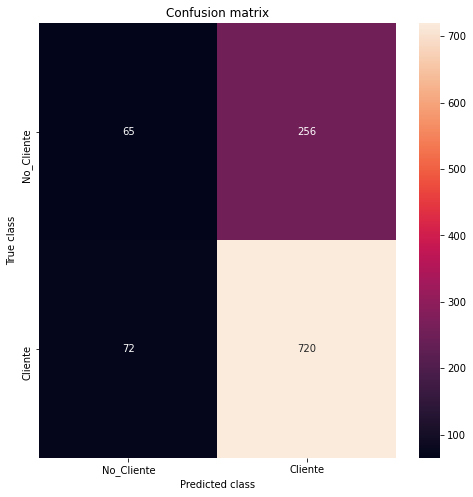

              precision    recall  f1-score   support

           0       0.47      0.20      0.28       321
           1       0.74      0.91      0.81       792

    accuracy                           0.71      1113
   macro avg       0.61      0.56      0.55      1113
weighted avg       0.66      0.71      0.66      1113



In [28]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [29]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [30]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
IPCASOS,6.036244
FECHA_ALTA_MONTH,6.033754
FECHACONSUMO_MONTH,5.743338
CANAL_REGISTRO,5.516310
FECHA_REGISTRO_MONTH,5.462719
1A_EMPCONSUL_PROV_DENS,5.317960
1A_EMPCONSUL_PROV_IDH,4.963623
FECHA_ALTA_WEEKDAY,4.608260
FECHACONSUMO_WEEKDAY,4.383941
FECHA_REGISTRO_WEEKDAY,3.959762


In [31]:
feature_importances[feature_importances['important'] > 0.01].shape

(25, 1)

------

------

------

#### 4.5 Modelo - Aplicando técnicas sobre el desbalanceo

**Estrategias para el manejo de Datos Desbalanceados**

##### **4.5.1 Penalización para compensar**

In [32]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123,
                            class_weight = 'balanced')

rf.fit(train_x, train_y)

RandomForestClassifier(class_weight='balanced', max_features='sqrt',
                       n_estimators=150, n_jobs=-1, random_state=123)

Observamos los resultados del modelo

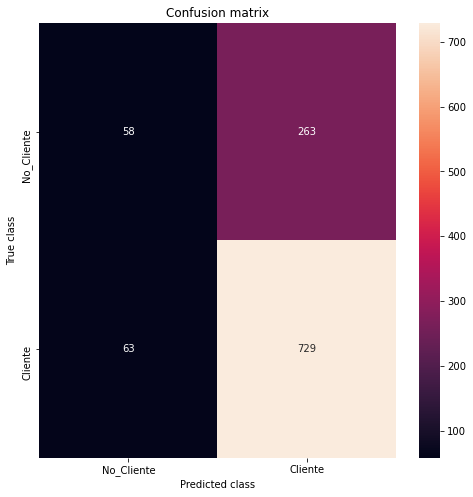

              precision    recall  f1-score   support

           0       0.48      0.18      0.26       321
           1       0.73      0.92      0.82       792

    accuracy                           0.71      1113
   macro avg       0.61      0.55      0.54      1113
weighted avg       0.66      0.71      0.66      1113



In [33]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [34]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [35]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FECHA_ALTA_MONTH,6.151675
FECHACONSUMO_MONTH,5.855970
IPCASOS,5.794187
CANAL_REGISTRO,5.530541
FECHA_REGISTRO_MONTH,5.276593
1A_EMPCONSUL_PROV_DENS,4.841599
1A_EMPCONSUL_PROV_IDH,4.686503
FECHA_ALTA_WEEKDAY,4.434792
FECHACONSUMO_WEEKDAY,4.020899
FECHA_REGISTRO_WEEKDAY,4.008217


In [36]:
feature_importances[feature_importances['important'] > 0.01].shape

(27, 1)

------

##### **4.5.2 Subsampling en la clase mayoritaria**

**RandomUnderSampler**

In [37]:
us = RandomUnderSampler(sampling_strategy = 'majority', random_state = 123)
X_train_res, y_train_res = us.fit_resample(train_x, train_y)
 
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({1: 1822, 0: 774})
Distribution after resampling Counter({0: 774, 1: 774})


In [38]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                       random_state=123)

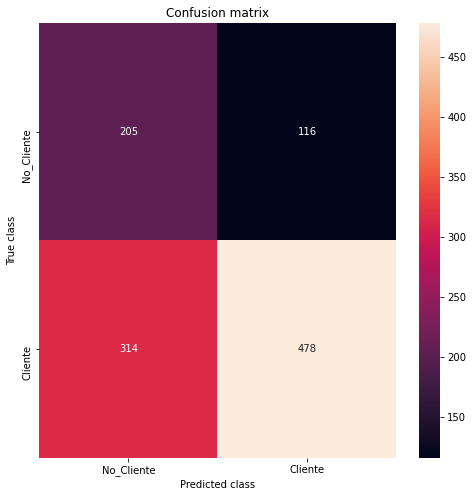

              precision    recall  f1-score   support

           0       0.39      0.64      0.49       321
           1       0.80      0.60      0.69       792

    accuracy                           0.61      1113
   macro avg       0.60      0.62      0.59      1113
weighted avg       0.69      0.61      0.63      1113



In [39]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [40]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [41]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FECHA_ALTA_MONTH,5.856505
IPCASOS,5.754373
FECHA_REGISTRO_MONTH,5.557751
FECHACONSUMO_MONTH,5.492152
CANAL_REGISTRO,5.345712
1A_EMPCONSUL_PROV_DENS,4.913978
1A_EMPCONSUL_PROV_IDH,4.516892
FECHA_ALTA_WEEKDAY,4.482353
FECHACONSUMO_WEEKDAY,4.147820
FECHA_REGISTRO_WEEKDAY,3.967977


In [42]:
feature_importances[feature_importances['important'] > 0.01].shape

(26, 1)

------

**NearMiss**

In [43]:
us = NearMiss(sampling_strategy = 'majority', n_neighbors = 2, n_jobs = -1)
X_train_res, y_train_res = us.fit_resample(train_x, train_y)
 
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({1: 1822, 0: 774})
Distribution after resampling Counter({0: 774, 1: 774})


In [44]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                       random_state=123)

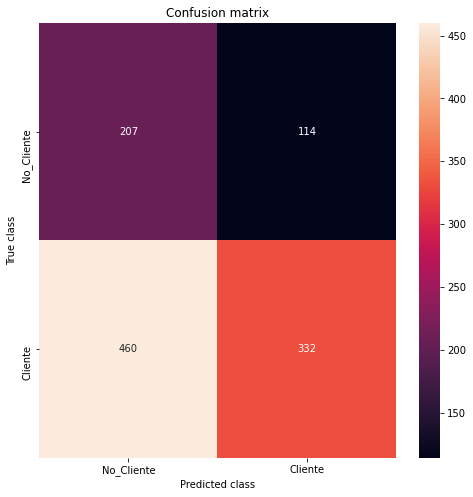

              precision    recall  f1-score   support

           0       0.31      0.64      0.42       321
           1       0.74      0.42      0.54       792

    accuracy                           0.48      1113
   macro avg       0.53      0.53      0.48      1113
weighted avg       0.62      0.48      0.50      1113



In [45]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [46]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [47]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
IPCASOS,8.764995
1A_EMPCONSUL_PROV_IDH,6.645734
1A_EMPCONSUL_PROV_DENS,6.251443
FECHA_ALTA_MONTH,5.890032
CANAL_REGISTRO,5.543545
FECHACONSUMO_MONTH,5.405022
FECHA_REGISTRO_MONTH,5.260494
FECHA_ALTA_WEEKDAY,4.392219
FECHACONSUMO_WEEKDAY,3.939037
FECHA_REGISTRO_WEEKDAY,3.878951


In [48]:
feature_importances[feature_importances['important'] > 0.01].shape

(25, 1)

------

------

##### **4.5.3 Oversampling en la clase minoritaria**

**SMOTE**

In [49]:
os =  SMOTE(sampling_strategy = 'minority')
X_train_res, y_train_res = os.fit_resample(train_x, train_y)

In [50]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({1: 1822, 0: 774})
Distribution labels after resampling Counter({1: 1822, 0: 1822})


In [51]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                       random_state=123)

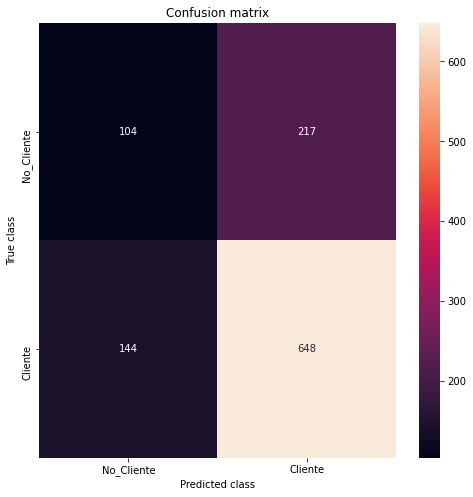

              precision    recall  f1-score   support

           0       0.42      0.32      0.37       321
           1       0.75      0.82      0.78       792

    accuracy                           0.68      1113
   macro avg       0.58      0.57      0.57      1113
weighted avg       0.65      0.68      0.66      1113



In [52]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [53]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [54]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FECHA_ALTA_MONTH,4.998126
CANAL_REGISTRO,4.842406
FECHACONSUMO_MONTH,4.794575
FECHA_REGISTRO_MONTH,4.605372
IPCASOS,4.426529
1A_EMPCONSUL_PROV_DENS,4.198080
1A_EMPCONSUL_PROV_IDH,3.928884
FECHA_ALTA_WEEKDAY,3.726870
FECHACONSUMO_WEEKDAY,3.554944
FECHA_REGISTRO_WEEKDAY,3.499049


In [55]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

------

**RandomOverSampler**

In [56]:
os =  RandomOverSampler(sampling_strategy = 'minority')
X_train_res, y_train_res = os.fit_resample(train_x, train_y)

In [57]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({1: 1822, 0: 774})
Distribution labels after resampling Counter({1: 1822, 0: 1822})


In [58]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                       random_state=123)

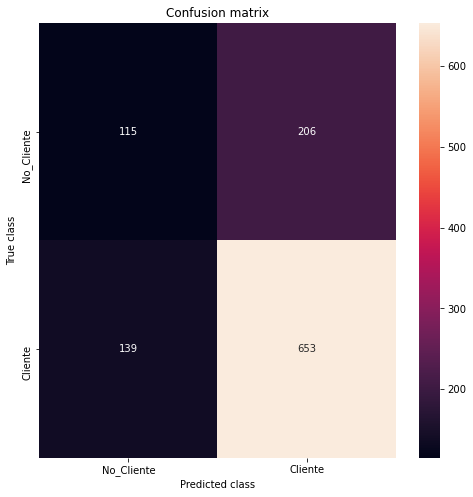

              precision    recall  f1-score   support

           0       0.45      0.36      0.40       321
           1       0.76      0.82      0.79       792

    accuracy                           0.69      1113
   macro avg       0.61      0.59      0.60      1113
weighted avg       0.67      0.69      0.68      1113



In [59]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [60]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [61]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FECHA_ALTA_MONTH,5.862412
IPCASOS,5.674300
FECHACONSUMO_MONTH,5.580872
CANAL_REGISTRO,5.527874
FECHA_REGISTRO_MONTH,5.477332
1A_EMPCONSUL_PROV_DENS,4.662125
1A_EMPCONSUL_PROV_IDH,4.502085
FECHA_ALTA_WEEKDAY,4.379934
FECHACONSUMO_WEEKDAY,4.137992
FECHA_REGISTRO_WEEKDAY,4.095096


In [62]:
feature_importances[feature_importances['important'] > 0.01].shape

(28, 1)

------

------

##### **4.5.4 Combinamos OverSampling con Subsampling**

**Combinando SMOTE & RandomUnderSampler**

In [63]:
over = SMOTE()
under = RandomUnderSampler()
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)

In [64]:
X_train_res, y_train_res = pipeline.fit_resample(train_x, train_y)

In [65]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({1: 1822, 0: 774})
Distribution after resampling Counter({0: 1822, 1: 1822})


In [66]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                       random_state=123)

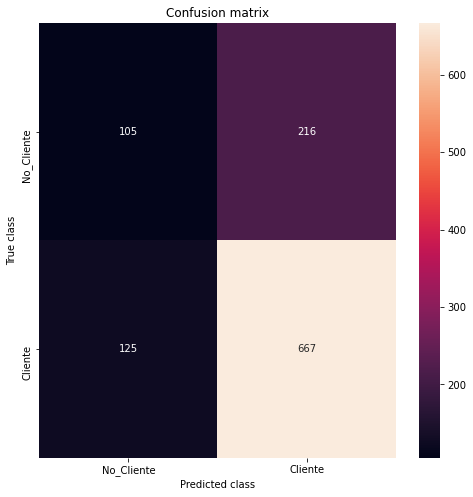

              precision    recall  f1-score   support

           0       0.46      0.33      0.38       321
           1       0.76      0.84      0.80       792

    accuracy                           0.69      1113
   macro avg       0.61      0.58      0.59      1113
weighted avg       0.67      0.69      0.68      1113



In [67]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [68]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [69]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
FECHA_ALTA_MONTH,5.062731
FECHA_REGISTRO_MONTH,4.713162
CANAL_REGISTRO,4.687176
FECHACONSUMO_MONTH,4.550523
IPCASOS,4.512704
1A_EMPCONSUL_PROV_DENS,4.272984
1A_EMPCONSUL_PROV_IDH,4.065849
FECHA_ALTA_WEEKDAY,3.777289
FECHACONSUMO_WEEKDAY,3.581790
FECHA_REGISTRO_WEEKDAY,3.579848


In [70]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

------

**Combinando SMOTE & NearMiss**

In [71]:
over = SMOTE(sampling_strategy = 'all')
under = NearMiss(sampling_strategy = 'majority', n_neighbors = 2, n_jobs = -1)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)

In [72]:
X_train_res, y_train_res = pipeline.fit_resample(train_x, train_y)

In [73]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({1: 1822, 0: 774})
Distribution after resampling Counter({0: 1822, 1: 1822})


In [74]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                       random_state=123)

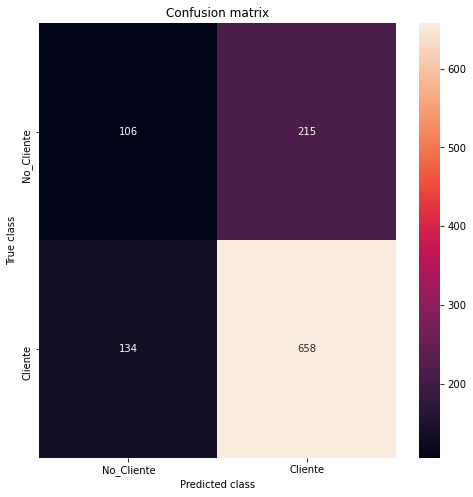

              precision    recall  f1-score   support

           0       0.44      0.33      0.38       321
           1       0.75      0.83      0.79       792

    accuracy                           0.69      1113
   macro avg       0.60      0.58      0.58      1113
weighted avg       0.66      0.69      0.67      1113



In [75]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [76]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [77]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
FECHA_ALTA_MONTH,5.000787
CANAL_REGISTRO,4.879415
FECHACONSUMO_MONTH,4.819739
FECHA_REGISTRO_MONTH,4.763458
IPCASOS,4.550223
1A_EMPCONSUL_PROV_DENS,4.312330
1A_EMPCONSUL_PROV_IDH,4.108910
FECHA_ALTA_WEEKDAY,3.741920
FECHACONSUMO_WEEKDAY,3.632764
FECHA_REGISTRO_WEEKDAY,3.546121


In [78]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

------

**SMOTETomek**

In [79]:
os_us = SMOTETomek(sampling_strategy = 'all')
X_train_res, y_train_res = os_us.fit_resample(train_x, train_y)

In [80]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({1: 1822, 0: 774})
Distribution after resampling Counter({1: 1752, 0: 1752})


In [81]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 20, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=20,
                       n_jobs=-1, random_state=123)

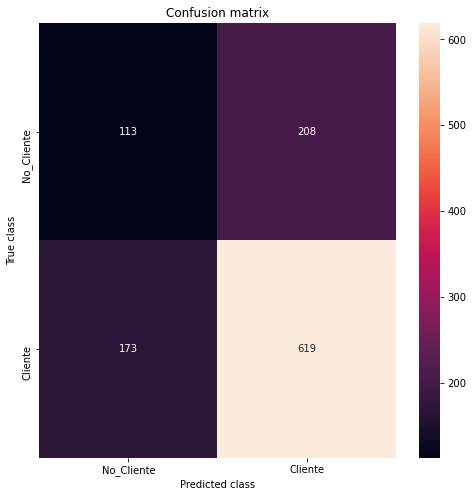

              precision    recall  f1-score   support

           0       0.40      0.35      0.37       321
           1       0.75      0.78      0.76       792

    accuracy                           0.66      1113
   macro avg       0.57      0.57      0.57      1113
weighted avg       0.65      0.66      0.65      1113



In [82]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [83]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [84]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
FECHA_ALTA_MONTH,5.273157
FECHA_REGISTRO_MONTH,5.055041
FECHACONSUMO_MONTH,4.855935
CANAL_REGISTRO,4.753014
1A_EMPCONSUL_PROV_DENS,4.609642
IPCASOS,4.563297
FECHA_ALTA_WEEKDAY,4.199821
1A_EMPCONSUL_PROV_IDH,4.022213
FECHA_REGISTRO_WEEKDAY,3.631551
FECHACONSUMO_WEEKDAY,3.564105


In [85]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

------

------

##### **4.5.5 Ensamble de Modelos con Balanceo**

Para esta estrategia usaremos un Clasificador de Ensamble que utiliza Bagging y el modelo será un RandomForest.

**Bagging**

In [86]:
bbc = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion = 'gini', 
                                                                        n_estimators = 150, 
                                                                        max_features = 'sqrt', 
                                                                        max_depth = None, 
                                                                        n_jobs = -1,
                                                                        random_state = 123),
                                sampling_strategy = 'all',
                                n_estimators = 20,
                                replacement = False,
                                random_state = 123)

bbc.fit(train_x, train_y)

BalancedBaggingClassifier(base_estimator=RandomForestClassifier(max_features='sqrt',
                                                                n_estimators=150,
                                                                n_jobs=-1,
                                                                random_state=123),
                          n_estimators=20, random_state=123,
                          sampling_strategy='all')

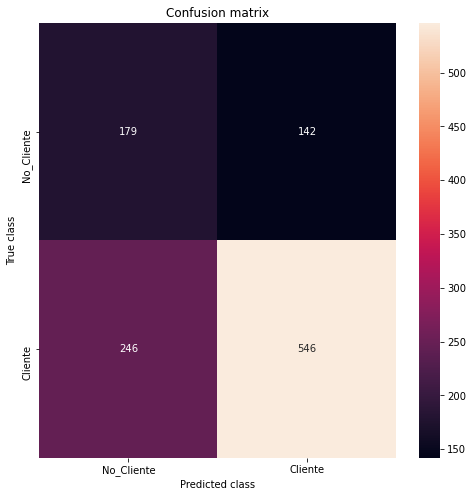

              precision    recall  f1-score   support

           0       0.42      0.56      0.48       321
           1       0.79      0.69      0.74       792

    accuracy                           0.65      1113
   macro avg       0.61      0.62      0.61      1113
weighted avg       0.69      0.65      0.66      1113



In [87]:
pred_y = bbc.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [88]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [89]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FECHA_ALTA_MONTH,5.273157
FECHA_REGISTRO_MONTH,5.055041
FECHACONSUMO_MONTH,4.855935
CANAL_REGISTRO,4.753014
1A_EMPCONSUL_PROV_DENS,4.609642
IPCASOS,4.563297
FECHA_ALTA_WEEKDAY,4.199821
1A_EMPCONSUL_PROV_IDH,4.022213
FECHA_REGISTRO_WEEKDAY,3.631551
FECHACONSUMO_WEEKDAY,3.564105


In [90]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

------

**BalancedRandomForestClassifier**

In [91]:
brfc = BalancedRandomForestClassifier(criterion = 'gini', 
                                    n_estimators = 150, 
                                    max_features = 'sqrt', 
                                    max_depth = None, 
                                    sampling_strategy = 'auto',
                                    n_jobs = -1,
                                    random_state = 123)

brfc.fit(train_x, train_y)

BalancedRandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                               random_state=123)

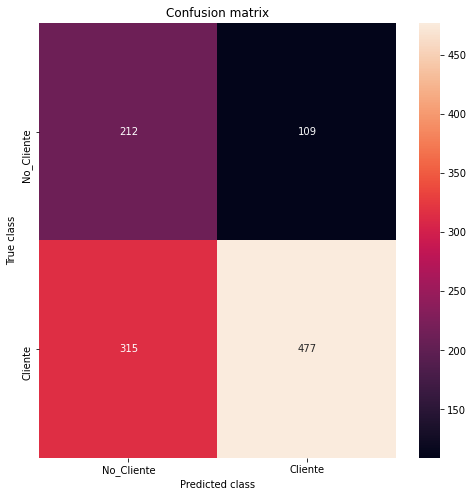

              precision    recall  f1-score   support

           0       0.40      0.66      0.50       321
           1       0.81      0.60      0.69       792

    accuracy                           0.62      1113
   macro avg       0.61      0.63      0.60      1113
weighted avg       0.70      0.62      0.64      1113



In [92]:
pred_y = brfc.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [93]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [94]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FECHA_ALTA_MONTH,5.273157
FECHA_REGISTRO_MONTH,5.055041
FECHACONSUMO_MONTH,4.855935
CANAL_REGISTRO,4.753014
1A_EMPCONSUL_PROV_DENS,4.609642
IPCASOS,4.563297
FECHA_ALTA_WEEKDAY,4.199821
1A_EMPCONSUL_PROV_IDH,4.022213
FECHA_REGISTRO_WEEKDAY,3.631551
FECHACONSUMO_WEEKDAY,3.564105


In [95]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

------

**RUSBoostClassifier**

In [96]:
RUS = RUSBoostClassifier(base_estimator = RandomForestClassifier(criterion = 'gini', 
                                                                n_estimators = 150, 
                                                                max_features = 'sqrt', 
                                                                max_depth = None, 
                                                                n_jobs = -1,
                                                                random_state = 123),
                                sampling_strategy = 'majority',
                                n_estimators = 20,
                                replacement = False,
                                random_state = 123)

RUS.fit(train_x, train_y)

RUSBoostClassifier(base_estimator=RandomForestClassifier(max_features='sqrt',
                                                         n_estimators=150,
                                                         n_jobs=-1,
                                                         random_state=123),
                   n_estimators=20, random_state=123,
                   sampling_strategy='majority')

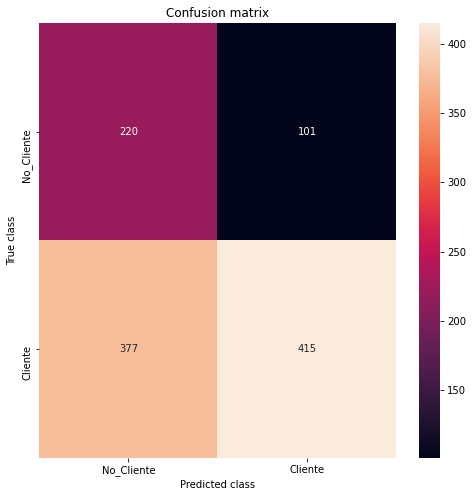

              precision    recall  f1-score   support

           0       0.37      0.69      0.48       321
           1       0.80      0.52      0.63       792

    accuracy                           0.57      1113
   macro avg       0.59      0.60      0.56      1113
weighted avg       0.68      0.57      0.59      1113



In [97]:
pred_y = RUS.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [98]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [99]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FECHA_ALTA_MONTH,5.273157
FECHA_REGISTRO_MONTH,5.055041
FECHACONSUMO_MONTH,4.855935
CANAL_REGISTRO,4.753014
1A_EMPCONSUL_PROV_DENS,4.609642
IPCASOS,4.563297
FECHA_ALTA_WEEKDAY,4.199821
1A_EMPCONSUL_PROV_IDH,4.022213
FECHA_REGISTRO_WEEKDAY,3.631551
FECHACONSUMO_WEEKDAY,3.564105


In [100]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

---------------

**EasyEnsembleClassifier**

In [101]:
Easy = EasyEnsembleClassifier(sampling_strategy = 'majority',
                              n_estimators = 150,
                              replacement = False,
                              random_state = 123)

Easy.fit(train_x, train_y)

EasyEnsembleClassifier(n_estimators=150, random_state=123,
                       sampling_strategy='majority')

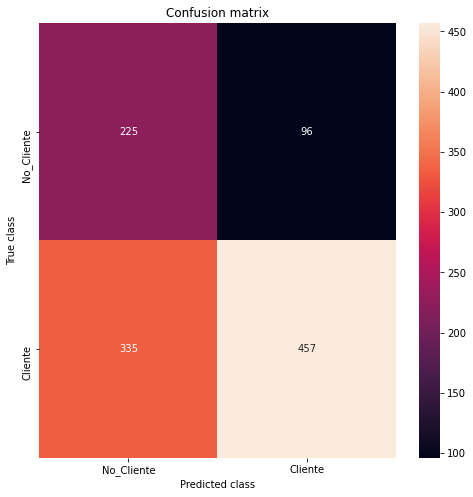

              precision    recall  f1-score   support

           0       0.40      0.70      0.51       321
           1       0.83      0.58      0.68       792

    accuracy                           0.61      1113
   macro avg       0.61      0.64      0.60      1113
weighted avg       0.70      0.61      0.63      1113



In [102]:
pred_y = Easy.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [103]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [104]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FECHA_ALTA_MONTH,5.273157
FECHA_REGISTRO_MONTH,5.055041
FECHACONSUMO_MONTH,4.855935
CANAL_REGISTRO,4.753014
1A_EMPCONSUL_PROV_DENS,4.609642
IPCASOS,4.563297
FECHA_ALTA_WEEKDAY,4.199821
1A_EMPCONSUL_PROV_IDH,4.022213
FECHA_REGISTRO_WEEKDAY,3.631551
FECHACONSUMO_WEEKDAY,3.564105


In [105]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

---------------

---------------

---------------

# CONCLUSIONES

Lo primero de todo comentar que el dataset en este notebook sufre un cambio, el numero de registros se reduce significativamente y el desbalanceo se torna al contrario, es decir, tenemos mas cliente que no clientes, por lo que al modelo le cosatará más identificar cuales son los no clientes.

Realizaremos un modleo base sobre el que comparar los resultados. 

| Modelo | Accuracy  | NoClientes - Precision  | NoClientes - Recall  | Clientes - Precision | Clientes - Recall | # Variables utilizadas
|---|:---:|:---:|:---:|:---:|:---:|:---:|
| Baseline | 0.71 | 0.47 | 0.20 |  0.74 | 0.91 | 25 |

### **Resultados** 

| Modelo |Tecnica |Algoritmo   | Accuracy  | NoClientes - Precision  | NoClientes - Recall  | Clientes - Precision | Clientes - Recall | # Variables utilizadas
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Modelo 1 | **Penalización para compensar** | | 0.71 | 0.48 | 0.18 | 0.73 | 0.92| 27 |
| Modelo 2 | **Subsampling en la clase mayoritaria** | RandomUnderSampler | 0.61 | 0.39 | 0.64 | 0.80 | 0.60 | 26 |
| Modelo 3 | **Subsampling en la clase mayoritaria** | NearMiss| 0.48 | 0.31 | 0.64 | 0.74 | 0.42 | 25 |
| Modelo 4 | **Oversampling en la clase minoritaria** | SMOTE| 0.68 | 0.42 | 0.32 | 0.75 | 0.82 | 32 |
| Modelo 5 | **Oversampling en la clase minoritaria** | RandomOverSampler| 0.69 | 0.45 | 0.36 | 0.76 | 0.82 | 28 |
| Modelo 6 | **Combinamos OverSampling con Subsampling** | SMOTE & RandomUnderSampler | 0.69 | 0.46 | 0.33 | 0.76 | 0.84 | 32 |
| Modelo 7 | **Combinamos OverSampling con Subsampling** | SMOTE & NearMiss | 0.69 | 0.44 | 0.33 | 0.75 | 0.83 | 32 |
| Modelo 8 | **Combinamos OverSampling con Subsampling** | SMOTE-Tomek| 0.66 | 0.40 | 0.35 | 0.75 | 0.78 | 32 |
| Modelo 9 | **Ensamble de Modelos con Balanceo** | BalancedBaggingClassifier| 0.65 | 0.42 | 0.56 | 0.79 | 0.69 | 32 |
| Modelo 10 | **Ensamble de Modelos con Balanceo** | BalancedRandomForestClassifier| 0.62 | 0.40 | 0.66 | 0.81 | 0.60 | 32 |
| Modelo 11 | **Ensamble de Modelos con Balanceo** | RUSBoostClassifier| 0.57 | 0.37 | 0.69 | 0.80 | 0.52 | 32 |
| Modelo 12 | **Ensamble de Modelos con Balanceo** | EasyEnsembleClassifier| 0.61 | 0.40 | 0.70 | 0.83 | 0.58 | 32 |

Tras los resultados obtenidos y expuestos, podemos concluir que la técnica que mejores resultados nos ha proporcionado es **En el que se aplica la penalización para compensar**. Podemos observar que su resultado es idéntico al modelo baseline. sobre el que no se alica ninguna técnica, esto es debido a que en este caso el dataset podemos considerarlo como equilibrado.

En el caso seleccionado como mejor modelo nos centramos en la métrica de recall, sobre todo en la clase mayoritaria, que en este caso son los objetivo, es decir los cliente. 

La técnica que más equilibrio presenta en la métrica de recall es la técnica **Penalización para compensar**. 